In [1]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer

%matplotlib inline

In [2]:
def prepare_image(file_path):
    img = plt.imread(file_path)
    return img

def binarize_label(file_name):
    if "bio" in file_name:
        return 0
    else:
        return 1

In [3]:
image_files = os.listdir("train_jpg")
train_images = [prepare_image("train_jpg/" + file) for file in image_files]
train_labels = [binarize_label(file) for file in image_files]

In [4]:
def process_image(img):
    img = cv2.resize(img, (400, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

In [5]:
for i in range(len(train_images)):
    train_images[i] = process_image(train_images[i])

In [6]:
train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(5720, 300, 400, 1) (5720,)


In [33]:
hidden_layers = [
    tf.keras.layers.Conv2D(filters=5, kernel_size=(3,3), padding="same", activation='relu', input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(3,3)),
    
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(3,3)),
    
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(3,3)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=30, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
]

NN = tf.keras.Sequential(hidden_layers)

NN.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[tf.metrics.SparseCategoricalAccuracy()])
NN.fit(train_images, train_labels, epochs=3, batch_size=50)
NN.save_weights("NNN.tf")

Epoch 1/3
115/115 [==============================] - 49s 423ms/step - loss: 0.4203 - sparse_categorical_accuracy: 0.7752
Epoch 2/3
115/115 [==============================] - 48s 421ms/step - loss: 0.2450 - sparse_categorical_accuracy: 0.9267
Epoch 3/3
115/115 [==============================] - 48s 417ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9654


In [34]:
NN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 300, 400, 5)       50        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 133, 5)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 133, 10)      460       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 33, 44, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 44, 20)        1820      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 15, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3300)             

In [37]:
val_files = os.listdir("val_jpg")
val_images = [prepare_image("val_jpg/" + file) for file in val_files]
val_labels = [binarize_label(file) for file in val_files]

validation_images = []

for i in range(len(val_images)):
    validation_images.append(process_image(val_images[i]))
    
val_model = tf.keras.Sequential(hidden_layers)
val_model.load_weights("NNN.tf")
val_predictions = val_model.predict(np.expand_dims(validation_images, axis=-1))

val_list = []

for i in range(len(val_predictions)):
    if np.argmax(val_predictions[i]) == 1:
        val_list.append(1)
    else:
        val_list.append(0)

error_count = 0
error_index_val = []

for i in range(len(val_list)):
    if val_list[i] != val_labels[i]:
        error_count += 1
        error_index_val.append(i)
        
print((len(val_list) - error_count)/len(val_list))
print(error_index_val)

0.8146341463414634
[5, 11, 13, 15, 20, 22, 44, 47, 51, 64, 67, 73, 75, 92, 93, 104, 105, 109, 128, 131, 160, 164, 177, 184, 188, 189, 190, 192, 195, 197, 215, 220, 224, 225, 231, 234, 237, 240, 241, 245, 257, 260, 262, 265, 267, 272, 285, 287, 289, 297, 299, 301, 302, 303, 310, 321, 325, 327, 329, 338, 349, 350, 363, 371, 374, 376, 377, 378, 380, 387, 398, 403, 407, 408, 414, 416, 417, 418, 419, 422, 431, 444, 447, 448, 452, 453, 455, 457, 464, 467, 470, 493, 494, 497, 498, 502, 503, 507, 508, 509, 514, 515, 518, 554, 555, 556, 561, 565, 570, 599, 601, 603, 605, 606, 620, 626, 632, 637, 638, 661, 664, 666, 668, 669, 687, 688, 690, 691, 692, 697, 705, 707, 724, 732, 735, 736, 741, 742, 744, 747, 758, 759, 761, 764, 800, 801, 805, 807, 808, 809, 811, 812]


In [36]:
test_files = os.listdir("test_jpg")
test_files_true = []

for file in test_files:
    if file != '.DS_Store':
        test_files_true.append(file)
        
test_images = [prepare_image("test_jpg/" + file) for file in test_files_true]
test_labels = [binarize_label(file) for file in test_files_true]

testing_images = []

for i in range(len(test_images)):
    testing_images.append(process_image(test_images[i]))
    
test_model = tf.keras.Sequential(hidden_layers)
test_model.load_weights("NNN.tf")
test_predictions = test_model.predict(np.expand_dims(testing_images, axis=-1))

test_list = []

for i in range(len(test_predictions)):
    if np.argmax(test_predictions[i]) == 1:
        test_list.append(1)
    else:
        test_list.append(0)

error_count = 0
error_index_test = []

for i in range(len(test_list)):
    if test_list[i] != test_labels[i]:
        error_count += 1
        error_index_test.append(i)
        
print((len(test_list) - error_count)/len(test_list))
print(error_index_test)

0.9694055944055944
[43, 65, 133, 134, 174, 192, 194, 199, 245, 315, 396, 465, 473, 476, 515, 604, 628, 689, 698, 736, 738, 786, 867, 869, 873, 883, 887, 898, 911, 1045, 1053, 1063, 1078, 1118, 1129]


<ipython-input-40-bb2dcb0f3735>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, position)


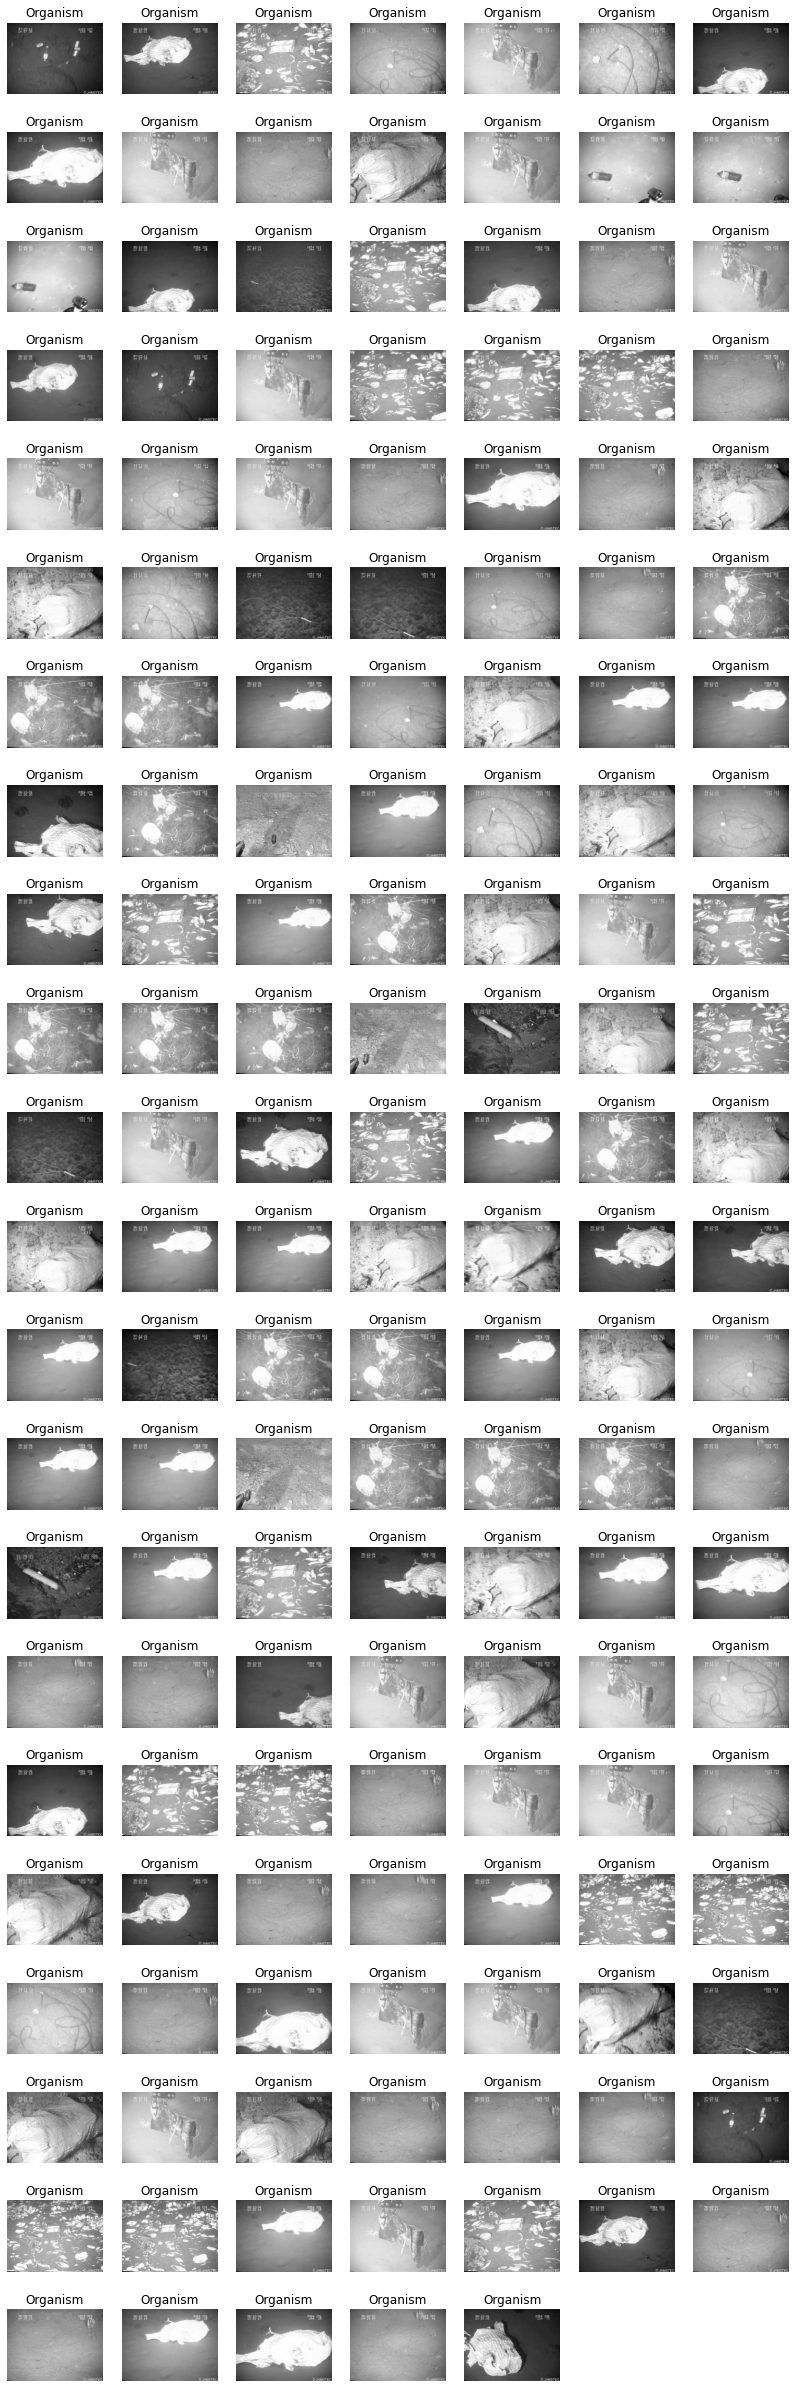

In [40]:
columns = 7
position = 1
rows = np.ceil(len(validation_images)/columns)
fig = plt.gcf()
fig.set_size_inches(cols * 2, rows * 2)
for i in error_index_val:
    plt.subplot(rows, cols, position)
    plt.imshow(validation_images[i], cmap="gray")
    plt.title("Trash" if np.argmax(val_predictions[i])==1 else "Organism")
    plt.axis('off')
    position += 1

<ipython-input-39-da3106cccd91>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, position)


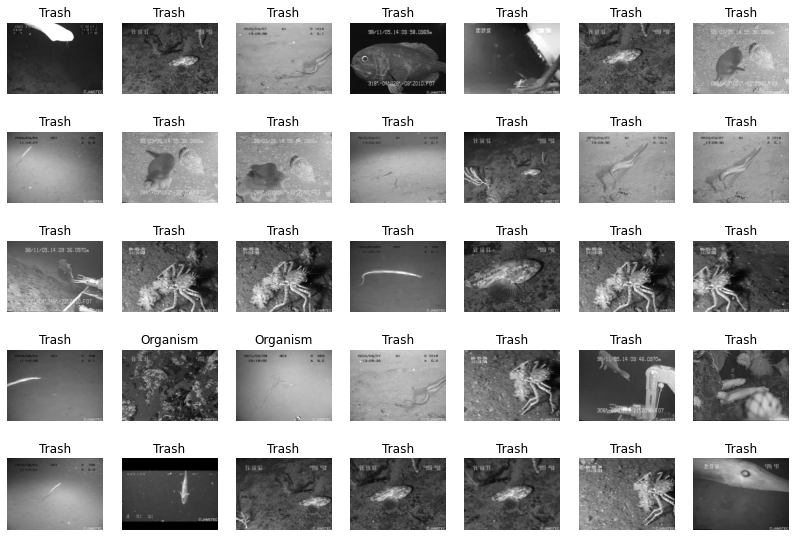

In [39]:
columns = 7
position = 1
rows = np.ceil(len(testing_images) / columns)
fig = plt.gcf()
fig.set_size_inches(cols * 2, rows * 2)
for i in error_index_test:
    plt.subplot(rows, cols, position)
    plt.imshow(testing_images[i], cmap="gray")
    plt.title("Trash" if np.argmax(test_predictions[i])==1 else "Organism")
    plt.axis('off')
    position += 1

In [51]:
trash_counter = 0
for i in range(len(val_labels)):
    if test_labels[i] == 0:
        trash_counter += 1
print(trash_counter)

198


Text(0.5, 15.0, 'Predicted Identification')

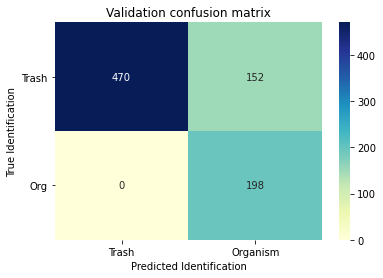

In [56]:
sns.heatmap([[470,  152],
             [0, 198]], annot = True, fmt='g', cmap="YlGnBu")
plt.title('Validation confusion matrix')
plt.ylabel('True Identification', rotation = 90)
plt.yticks(ticks = [0.5, 1.5], labels = ['Trash', 'Org'], rotation = 0)
plt.xticks(ticks = [0.5, 1.5], labels = ['Trash', 'Organism'], rotation = 0)
plt.xlabel('Predicted Identification')

Text(0.5, 15.0, 'Predicted Identification')

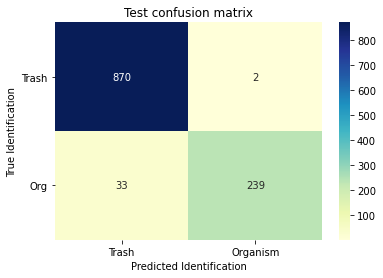

In [57]:
sns.heatmap([[870,  2],
             [33, 239]], annot = True, fmt='g', cmap="YlGnBu")
plt.title('Test confusion matrix')
plt.ylabel('True Identification', rotation = 90)
plt.yticks(ticks = [0.5, 1.5], labels = ['Trash', 'Org'], rotation = 0)
plt.xticks(ticks = [0.5, 1.5], labels = ['Trash', 'Organism'], rotation = 0)
plt.xlabel('Predicted Identification')

In [59]:
precision_val = 470/(470)
recall_val = 470/(470+152)
F1_val = (2 * precision_val * recall_val) / (precision_val + recall_val)

precision_test = 870/(870+33)
recall_test = 870/(870+2)
F1_test = (2 * precision_test * recall_test) / (precision_test + recall_test)

print("validation precision: ", + precision_val)
print("validation recall: ", + recall_val)
print("validation F1: ", + F1_val)
print("\n")
print("test precision: ", + precision_test)
print("test recall: ", + recall_test)
print("test F1: ", + F1_test)

validation precision:  1.0
validation recall:  0.7556270096463023
validation F1:  0.8608058608058609


test precision:  0.9634551495016611
test recall:  0.9977064220183486
test F1:  0.980281690140845


In [ ]:
hidden_layers2 = [
    tf.keras.layers.Conv2D(filters=5, kernel_size=(3,3), padding="same", activation='relu', input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(3,3)),
    
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(3,3)),
    
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(3,3)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=30, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
]

NN = tf.keras.Sequential(hidden_layers2)

NN2.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[tf.metrics.SparseCategoricalAccuracy()])
NN2.fit(train_images, train_labels, epochs=3, batch_size=50)
NN2.save_weights("NN2.tf")